In [2]:
import numpy as np
from scipy  import stats
import math
#import seaborn as sns
# Creating a DataFrame for seaborn
#import pandas as pd
import matplotlib.pyplot as plt


In [7]:
#Generate full data
def sim(alpha = 0.9, beta = 0.2, 
        gamma = 0.1, lambda0 = 1, lambda1 =5, n = 100, T = 10, C1 = 2):
    #Create CPD Gamma matrix
    matrix_CPD = np.array([
    [1 - gamma, 0, gamma],
    [0, 1 - gamma, gamma],
    [beta / 2, beta / 2, 1 - beta]
])
    #method for translating multinomial to single values    
    translate_val = {(1,0,0): 0, (0,1,0): 1, (0,0,1): 2}

    #CPD for Z_t_i
    z_t_i_CPD = {0: 1-alpha, 1: alpha, 2: 0.5}


    def generate_C(T = T, C1 = C1):
        C_list = [C1]
        for i in range(T-1):
            C_i_CPD = list(matrix_CPD[C_list[i]])
            C = translate_val[tuple(np.random.multinomial(1, pvals = C_i_CPD))]
            C_list.append(C)
        return C_list

    def generate_z_t(Cs, n = n):
        probabilities = [z_t_i_CPD[C_i] for C_i in Cs]
        
        return [np.random.binomial(1, p = prob, size = n) for prob in probabilities]
    
        
    Cs = generate_C(T, C1)
    Zs = generate_z_t(Cs, n = n) 
    Z_flat = np.array(Zs).flat
    Xs = np.reshape([np.random.poisson(lambda0+(lambda1-lambda0)*z) for z in Z_flat], newshape=(T, n))
    return [list(range(T)),Cs, Zs, Xs]
    

ls = sim(n = 2, T = 100, C1 = 2, lambda1 = 10)


In [ ]:
# Example data
T = ls[0]
C = ls[1]
Z = ls[2]
X = ls[3]


df = pd.DataFrame({'T': np.tile(T, len(X[0])), 'C': np.tile(C, len(X[0])), 'Z' : np.concatenate(Z), 'X': np.concatenate(X),  'List': np.repeat(np.arange(len(X[0])), len(T))})


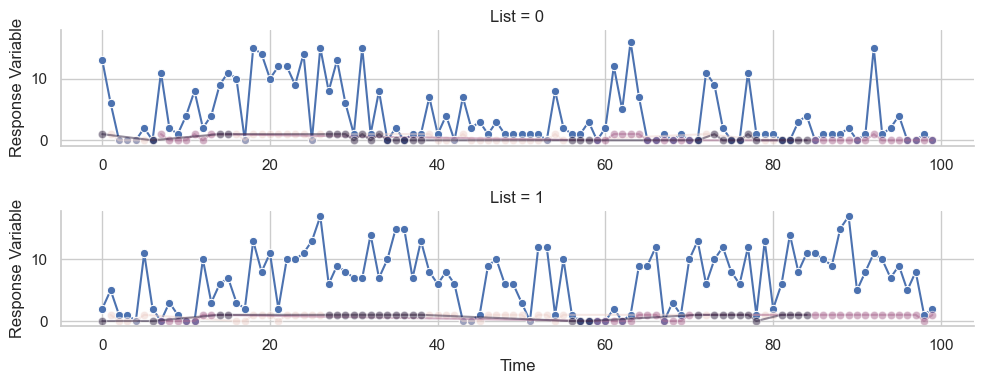

In [ ]:

sns.set(style="whitegrid")
g = sns.FacetGrid(df, row="List", sharex=False, sharey=True, aspect=5, height=2)
g.map(sns.lineplot, 'T', 'X', alpha=1, marker='o', linestyle='-')
g.map(sns.lineplot, 'T', 'Z', alpha=0.5, marker='o', hue = df['C'])
g.set_axis_labels("Time", "Response Variable")
#g.set_titles(col_template="List {col_name}")
plt.show()

In [8]:
#Parameters:
gamma = 0.1
beta = 0.2
alpha = 0.9
lamb0=1
lamb1=5

#important properties
Gamma = np.array([[1-gamma, 0, gamma], 
                      [0, 1-gamma, gamma], 
                      [beta/2, beta/2, 1-beta]])
alpha_C = np.array([1-alpha, alpha,0.5])
lamb_Z = np.array([lamb0, lamb1])



In [3]:
def sim(n=2, T=1000, alpha = 0.9, beta = 0.2, gamma = 0.1, lamb0=1, lamb1=5):
    #Defining the three possible values of C
    ck = np.arange(3)   
    
    #Gamma matrix for assigning P(C_t | C_{t-1})
    Gamma = np.array([[1-gamma, 0, gamma], 
                      [0, 1-gamma, gamma], 
                      [beta/2, beta/2, 1-beta]])
    
    #Creating random variables with probabilities based of the gamma matrix
    C_transition = [
        stats.rv_discrete(values=(ck,Gamma[0,])),#P(C_t |C_{t-1} = 0)
        stats.rv_discrete(values=(ck,Gamma[1,])),#P(C_t |C_{t-1} = 1)
        stats.rv_discrete(values=(ck,Gamma[2,])),#P(C_t |C_{t-1} = 2)
    ]

    #Creating output vector of C's
    C = np.zeros(T, np.int64)
    #Initializing the C vector
    C[0] = 2

    #Filling up the C-vector with values
    for i in range(T-1):
        C[i+1] = C_transition[C[i]].rvs()
    
    #CPT of Z
    Z_given_C = np.array([1-alpha, alpha, 0.5])  #P(Z = 1| C =c)
    
    #Initializing Z. size=[n,T] specifies we need to create n copies of a series of T simulations
    Z = stats.bernoulli(Z_given_C[C]).rvs(size=[n,T])
    #input:
    '''
    [C_1, C_2, ... C_T]
    '''
    
    #output: 
    '''[   
        [Z_11, Z_21, Z_31, ... , Z_T1]
        [Z_12, Z_22, Z_32, ... , Z_T2]
        ...
        [Z_1n, Z_2n, Z_3n, ... , Z_Tn]
    ]'''

    #Initialize X   
    X = stats.poisson(np.where(Z, lamb1, lamb0)).rvs()
    #input
    '''[   
        [f(Z_11), f(Z_21), f(Z_31), ... , f(Z_T1)]
        [f(Z_12), f(Z_22), f(Z_32), ... , f(Z_T2)]
        ...
        [f(Z_1n), f(Z_2n), f(Z_3n), ... , f(Z_Tn)]
        ]    
        where
        f(z) = lamb0+(lamb1-lamb0)*z
    '''

    #output
    '''[   
        [X_11, X_21, X_31, ... , X_T1]
        [X_12, X_22, X_32, ... , X_T2]
        ...
        [X_1n, X_2n, X_3n, ... , X_Tn]
    ]'''

    return C,Z,X

In [79]:
#HELPER FUNCTIONS TO ENSURE FORMATTING WORKS
def get_T(X):
    return(np.shape(X)[1])

def get_n(X):
    return(np.shape(X)[0])

def get_Xij(X, time, neuron_n):
    return X[neuron_n, time]

def get_delta_Mij_to_Li(array, time, neuron):
    return array[time, neuron] #returns function of Ci

def get_delta_Li_to_Mij(array, time, neuron):
    return array[time, neuron] #returns function of Ci

def get_delta_Li__to_Li_val(array, i, Cval):
    return array[i, Cval] #returns message value for time i and Cval = Cval

def get_prod_delta_Mij_to_Li_val(array, time, Cval):
    return array[time, Cval] #returns message value at time i and Cval

def get_belief_Li(array, time):
    return array[time]

#MESSAGE PASSING

Cliques:
\begin{align*}
L_i &= \{C_i, C_{i+1}\}, \text{ for } i = 1, \ldots, T-1\\
M_{i,j} &= \{X_{i,j}, Z_{i,j}, C_i\} \text{ for } i = 1, \ldots, T \quad j = 1, \ldots, n
\end{align*}
Clique potentials

\begin{align*}
\psi_{L_1}(C_1, C_2) &= P(C_1)P(C_2 \mid C_1)\\
\psi_{L_i}(C_{i}, C_{i+1}) &= P(C_{i+1} \mid C_{i}) \text{ for } i = 2, \ldots , T-1\\
\psi_{M_{i,j}}(Z_{i,j}, X_{i,j}, C_i) &= P(Z_{i,j} \mid C_i)P(X_{i,j} \mid Z_{i,j}) \text{ for } j = 1, \ldots, n, \quad i = 1, \ldots, T\\
&= (Z_{i,j}\alpha_{C_i}+(1-\alpha_{C_i})(1-Z_{i,j}))\cdot \exp(-\lambda_{Z_{i,j}})\frac{\lambda_{Z_{i,j}}^{X_{i,j}}}{X_{i,j}!}
\end{align*}



In [6]:

def psi_L_1(C1,C2, Gamma = Gamma):
   return(Gamma[C1, C2]*[0,0,1][C1])

def psi_L_i(C_i_plus, C_i, Gamma = Gamma): # i = 2, ..., T-1
   
   return Gamma[C_i, C_i_plus]

def psi_M_ij (Xij, Ci, Zij, lamb_Z = lamb_Z, alpha_C = alpha_C):
   prob_Z_given_C = Zij*alpha_C[Ci]+(1-Zij)*(1-alpha_C[Ci])
   prob_X_given_Z = math.exp(-lamb_Z[Zij])*(lamb_Z[Zij]**Xij)/math.factorial(Xij)
   return(prob_Z_given_C*prob_X_given_Z)     


NameError: name 'Gamma' is not defined

Message Passing upwards
\begin{align*}
\delta_{M_{i,j} \to L_i}(C_i \mid X_{i,j}) &= \sum_{Z_{i,j} = 0}^1 \psi_{M_{i,j}}(Z_{i,j}, X_{i,j}, C_i)\\
&= \frac{\exp(\lambda_{0})}{x!}\left(\lambda_0^x + \alpha_{C_i}\left(\exp(\lambda_1-\lambda_0)\lambda_1^x - \lambda_0^x \right) \right)\\
\delta_{L_{i-1} \to L_i}(C_i \mid X_{i-1}) &= \sum_{C_{i-1} =0 }^2 \psi_{L_{i-1}}(C_{i-1}, C_i)\prod_{j = 1}^n \delta_{M_{i-1,j} \to L_{i-1}}(C_{i-1}, X_{i-1, j}) \text{ for } i = 2, \ldots, T-1
\end{align*}



In [81]:
def delta_Mij_to_Li(Ci, Xij, psi_M_ij):   #(Zij, Ci | Xij) -> (Ci | Xij) for j = 1..n, i = 1..T
    #Xij = X[i-1,j-1] due to indexing
    return sum([psi_M_ij(Xij = Xij, Ci = Ci, Zij=z) for z in range(2)]) #(Ci)

def delta_Li_min_to_Li(Ci, X, i):     #(Ci_, Ci | Xi_s) -> (Ci | Xi_s) for i = 2.. T-1
    if i == 1:
        return 1
    Xi_s = X[i] #(n)
    incoming_messages = [math.prod([delta_Mij_to_Li(Ci  = C_minus, Xij=x) for x in Xi_s]) for C_minus in range(3)] #(Ci)
    scaled_incoming = incoming_messages/sum(incoming_messages) #(Ci)
    return sum([scaled_incoming[C_minus]*psi_L_i(C_i= C_minus,  C_i_plus = Ci)*delta_Li_min_to_Li(Ci=C_minus, X = X, i = i-1) for C_minus in range(3)]) #(Ci)

CLIQUE BELIEF LT
\begin{align*}
\beta_{C_{T}, C_{T-1}}(X) &=  \prod_{j = 1}^{n}  \delta_{M_{T,j} \to L_{T-1}}(C_T, X_T)   \delta_{L_{T-2} \to L_{T-1}}(C_{T-1}, X_{T-2}) \delta_{M_{T-1,j} \to L_{T-1}}(C_{T-1}, X_{T-1})\\
&= P(C_T, C_{T-1} \mid X)
\end{align*}

In [77]:
def find_all_delta_Mij_to_Li(X, psi_M_ij): #X_input (n, T); Output_shape = (T, n, C_val) (normalized) #shape: (T, n, Cval)
    #Finding shape from X
    T = get_T(X)
    n = get_n(X)

    #unnormalized messages
    unorm_delta = np.array([[[delta_Mij_to_Li(Ci = C_i, Xij = X[j, i], psi_M_ij= psi_M_ij) for C_i in range(3)]  for j in range(n)] for i in range(T)]) #/ max([delta_Mij_to_Li(Ci = C_i, Xij = X[j, i]) for C_i in range(3)])  old ending  
    #normalizing    
    norm_delta = np.array([[unorm_delta[i, j] / np.sum(unorm_delta[i, j]) for j in range(n)] for i in range(T)])
    return unorm_delta #(T, n, C)

def prod_mij_to_Li(X, list_of_mij_Li_message):  #shape: (T, C_val)
    T = get_T(X)
    #calculating the product terms of all incoming messages for every time, T
    prod_terms = np.array([np.prod(list_of_mij_Li_message[i], axis = 0) for i in range(0, T)]) #output (T, C_val)
    normalized_prod_terms = np.array([prod_terms[i]/ np.sum(prod_terms[i]) for i in range(T)])

    return normalized_prod_terms #(T, C)

def find_all_delta_Li_min_to_Li(X, list_of_prod_mij_to_Li, psi_L_1, psi_L_i): #X_input (n, T); Y_input (T, n, C_val); Output_shape = (T, Cival) (normalized) 

    T = get_T(X)
    number_of_messages = T-2 #T-1 cliques (nodes) and T-1-1 messages (edges)
    array_delta_Li_to_Li_plus = np.empty((number_of_messages, 3)) #Times, Cval
    
    
    for i in range(number_of_messages): #Max Li is L_{T-1} and remember zero indexing
        #first time has slightly different psi_L_1
        print("incoming product is \n",list_of_prod_mij_to_Li[i] )
        if i == 0:
            unorm = np.array([sum([psi_L_1(C1 = C1, C2 = C2)*list_of_prod_mij_to_Li[i][C1] for C1 in range(3)]) for C2 in range(3)]) #C2

        #all the other terms are the same
        else:
            unorm = np.array([sum([psi_L_i(C_i = Ci, C_i_plus= Ci_plus)*list_of_prod_mij_to_Li[i][Ci]*array_delta_Li_to_Li_plus[i-1][Ci] for Ci in range(3)]) for Ci_plus in range(3)]) #output (T, Ci_plus) (summing out Ci)
        
        #normalizing
        array_delta_Li_to_Li_plus[i] = unorm/np.max(unorm)
   
    return array_delta_Li_to_Li_plus #shape: (T-2, Cval), first C = C_2, last C = C_{T_1}

In [83]:
def belief_LT_(ar_d_Li__to_L_i, ar_prod_d_Mij_to_Li, psi_L_i):
    #unnormalized    
    beta_LT_ = np.array([[get_delta_Li__to_Li_val(ar_d_Li__to_L_i, i = -1, Cval = CT_)* #finding for messagevalue to last clique and values C_{T-1}
                          get_prod_delta_Mij_to_Li_val(ar_prod_d_Mij_to_Li, time =-1, Cval = CT)* 
                          get_prod_delta_Mij_to_Li_val(ar_prod_d_Mij_to_Li, time = -2, Cval = CT_)*
                           psi_L_i(C_i_plus = CT, C_i = CT_) for CT_ in range(3)] for CT in range(3)]) #(CT, CT_)
    #normalized
    prob  = beta_LT_/np.sum(beta_LT_)
    return prob

def downwards_passing(X, belief_LT_, array_delta_Li_to_L_i_plus, array_prod_delta_Mij_to_Li, psi_L_i, psi_L_1):
    T = get_T(X)
    number_of_messages = T-2
    number_of_cliques = T-1
    #storage arrays
    array_belief_Li = np.empty((number_of_cliques, 3, 3)) #(T-1, C_{i+1}, C_{i})
    array_delta_Li_plus_to_Li = np.empty((number_of_messages, 3))  #T, Ci

    #adding first element
    array_belief_Li[-1] = belief_LT_ #(C_{T}, C_{T-1})
    #print("-------- STATUS ----")
    print("Upwards messages are:\n", array_delta_Li_to_L_i_plus)
    print("upwards message shape is", array_delta_Li_to_L_i_plus.shape)
    #print("mij_prod shape is", array_prod_delta_Mij_to_Li.shape)
    #print("all")

    #for each i in [0,T-2) first calculate incoming messages, then find clique belief 
    for i  in range(number_of_cliques-1)[::-1]: #finding the other cliques, alrady found the last
        
        print("#----- i = ",  i)
        #--- INCOMING MESSAGES to clique Li----#
        #Fetching message from earlier
        if i == 0:
            incoming_message_below = 1
        elif i != 0:    
            incoming_message_below = array_delta_Li_to_L_i_plus[i] #(Ci)

        incoming_prod_mij = array_prod_delta_Mij_to_Li[i] #(Ci)
        #remember to remove the message that was sent out already
        #-------Check if this is correct-------
        belief_above = array_belief_Li[i+1]
        #print("unchanged belief above: \n", belief_above)
        print("message sent upwards earlier\n", array_delta_Li_to_L_i_plus[i])
        #---- delta_{{Li+1} -> Li }-------------
        incoming_message_above_unorm = np.array([sum([array_belief_Li[i+1, Ci_plus2, Ciplus1] for Ci_plus2 in range(3)]) for Ciplus1 in range(3)])/array_delta_Li_to_L_i_plus[i] #(Ci+)
        print("above message before division \n", [sum([array_belief_Li[i+1, Ci_plus2, Ciplus1] for Ci_plus2 in range(3)]) for Ciplus1 in range(3)])
        print("Dividing with \n", array_delta_Li_to_L_i_plus[i])
        print("message above\n", incoming_message_above_unorm)
        #normalizing
        incoming_message_above = incoming_message_above_unorm/np.max(incoming_message_above_unorm)
        array_delta_Li_plus_to_Li[i] = incoming_message_above

        #print("incoming messages are:\n L_{i+1} -> L_i: \n", incoming_message_above, "\n  L_{i-1} -> L_i: \n", incoming_message_below,"\n Mi -> Li \n", incoming_prod_mij)
        
        #---- CALCULATE CLIQUE BELIEF --- #
        #finding delta_above(Ci+)*delta_below(Ci)*delta_prod(Ci)*
        if i != 0:
            belief_Li_unorm = np.array([[incoming_message_below[Ci]*incoming_message_above[Ci_plus]*incoming_prod_mij[Ci]*psi_L_i(C_i_plus = Ci_plus, C_i = Ci) for Ci_plus in range(3)] for Ci in range(3)])
        
        if i == 0:
            belief_Li_unorm = np.array([[incoming_message_below*incoming_message_above[C2]*incoming_prod_mij[C1]*psi_L_1(C2 = C2, C1 = C1) for C2 in range(3)] for C1 in range(3)])

        #normalizing
        belief_Li = belief_Li_unorm/np.sum(belief_Li_unorm)
        #print("calculated belief:\n", np.around(belief_Li, decimals = 2))
        #saving for later
        array_delta_Li_plus_to_Li[i] = incoming_message_above
        array_belief_Li[i] = belief_Li

    

    return array_belief_Li, array_delta_Li_plus_to_Li  #(T, C_{i+1}, C_i) x (T, C_i)

def delta_Li_to_Mij(X, array_belief_Li, array_delta_Mij_to_Li):
    T = get_T(X)
    n = get_n(X)

    array_delta_Li_to_Mij = np.empty(array_delta_Mij_to_Li.shape) #(T, n, C)
    
    for i in range(T): #time
        #finding current belief and summing out irrelevant variable
        if i == T-1:
            current_belief = array_belief_Li[i-1]
            marginal_belief = np.array([sum([current_belief[Ci, Ci_] for Ci_ in range(3)]) for Ci in range(3)]) #ci
        else:
            current_belief = array_belief_Li[i]
            marginal_belief = np.array([sum([current_belief[Ci_plus, Ci] for Ci_plus in range(3)]) for Ci in range(3)]) #ci
        
        for j in range(n): #for every neuron we need to find message
            unorm = marginal_belief/get_delta_Mij_to_Li(array_delta_Mij_to_Li, time = i, neuron= j)
            norm = unorm/np.max(unorm)
            array_delta_Li_to_Mij[i,j] = norm
    
    return array_delta_Li_to_Mij #(T, n, C)

In [85]:
def belief_Zij(X, array_delta_Li_to_Mij, psi_M_ij):
    T = get_T(X)
    n = get_n(X)
    #print(array_delta_Li_to_Mij)
    array_belief_Zij = np.empty(shape=(T, n, 2))
    for i in range(T):
        for j in range(n):
            #fecth X_ij value
            Xij = get_Xij(X, time = i, neuron_n=j)
            #calculate clique belief by multipying incoming message with original factor
            belief_Zij_unorm = np.array([sum([get_delta_Li_to_Mij(array_delta_Li_to_Mij,time = i, neuron = j)[Cval]*
                                              psi_M_ij(Xij=Xij, Ci = Cval, Zij = Z) for Cval in range(3)]) for Z in range(2)])
            #normalizing
            belief_Zij = belief_Zij_unorm/np.sum(belief_Zij_unorm)
            #store value
            array_belief_Zij[i, j] = belief_Zij
    return array_belief_Zij

def prob_Ci(belief_Li, X):
    T = get_T(X)
    #array_belief_Li #(T, C_{i}, C_i+)
    prob_C_array = np.empty((T, 2, 3)) #(T, (beta_i, beta_{i+1})) #two values for each
    for i in range(T):

        if i == 0:
            unorm0 = np.array([sum([belief_Li[i, C0, C1] for C1 in range(3)]) for C0 in range(3)])
            unorm1 = unorm0

        elif i == T-1:
            unorm0 = np.array([sum([belief_Li[i-1, CT_, CT] for CT_ in range(3)]) for CT in range(3)])
            unorm1 = unorm0

        else:
            unorm0  = np.array([sum([belief_Li[i-1, Ci_, Ci] for Ci_ in range(3)]) for Ci in range(3)])
            unorm1 = np.array([sum([belief_Li[i, Ci, Ci_plus] for Ci_plus in range(3)]) for Ci in range(3)])

        prob_C_array[i,0] = unorm0/np.sum(unorm0)
        prob_C_array[i,1] = unorm1/np.sum(unorm1)
        print("for i = ", i, "P(Ci|X) is \n", np.around(prob_C_array[i], decimals = 2))
        
    return prob_C_array


In [86]:
def find_beliefs(X, lamb0 = 1, lamb1 = 5, alpha = 0.9, gamma = 0.1, beta = 0.2):
    print("alpha is assumed to be ", alpha)
    print("beta is assumed to be ", beta)
    #important properties
    Gamma = np.array([[1-gamma, 0, gamma], 
                          [0, 1-gamma, gamma], 
                          [beta/2, beta/2, 1-beta]])
    
    alpha_C = np.array([1-alpha, alpha, 0.5])

    lamb_Z = np.array([lamb0, lamb1])

    

    def psi_M_ij (Xij, Ci, Zij, lamb_Z = lamb_Z, alpha_C = alpha_C):   #chosen factor for clique Mij
       
        #definition of prob Z given C
        prob_Z_given_C = Zij*alpha_C[Ci]+(1-Zij)*(1-alpha_C[Ci])
        #print("prob Z = ", Zij,"given C = ", Ci, " is ", prob_Z_given_C)
        
        #definition of X given Z
        prob_X_given_Z = math.exp(-lamb_Z[Zij])*(lamb_Z[Zij]**Xij)/math.factorial(Xij)
        #print("prob X = ", Xij,"given Z = ", Zij, " is ", prob_X_given_Z)
        return(prob_Z_given_C*prob_X_given_Z)  

    
    def psi_L_1(C1,C2, Gamma = Gamma):              #Chosen factor 1
       return(Gamma[C1, C2]*[0,0,1][C1])

    def psi_L_i(C_i_plus, C_i, Gamma = Gamma): # i = 2, ..., T-1    #Chosen factor for clique Li
        return Gamma[C_i, C_i_plus]

    def delta_Mij_to_Li(Ci, Xij):   #(Zij, Ci | Xij) -> (Ci | Xij) for j = 1..n, i = 1..T
        return sum([psi_M_ij(Xij = Xij, Ci = Ci, Zij=z) for z in range(2)])
   

    def delta_Li_min_to_Li(Ci, X, i):     #(Ci_, Ci | Xi_s) -> (Ci | Xi_s) for i = 2.. T-1
        if i == 1:
            return 1

        Xi_s = X[i]

        incoming_messages = [math.prod([delta_Mij_to_Li(Ci  = C_minus, Xij=x) for x in Xi_s]) for C_minus in range(3)]
        scaled_incoming = incoming_messages/sum(incoming_messages)
        return sum([scaled_incoming[C_minus]*psi_L_i(C_i= C_minus,  C_i_plus = Ci)*delta_Li_min_to_Li(Ci=C_minus, X = X, i = i-1) for C_minus in range(3)])
    
    #find all upwards messages
    #--------THIS PROVIDES THE CORRECT ANSWER ----- #
    array_delta_Mij_to_Li = find_all_delta_Mij_to_Li(X, psi_M_ij=psi_M_ij) #shape(T,n , Cval)
    print("individual messages are\n", array_delta_Mij_to_Li)
    
    #THIS HAS BEEN DOUBLE CHECKED AND PROVIDES THE CORRECT
    #calculating once for later
    array_prod_delta_Mij_to_Li = prod_mij_to_Li(X = X, list_of_mij_Li_message = array_delta_Mij_to_Li) #shape: (T, C_val)
    #print("product messages are \n", array_prod_delta_Mij_to_Li)
    
    #L_{i-1} -> L_i messages
    #calculating once for later
    #------- HIS HAS BEEN DOUBLE CHECKED AND PROVIDES answers that make sense ----#
    array_delta_Li_to_L_i_plus = find_all_delta_Li_min_to_Li(X = X, list_of_prod_mij_to_Li=array_prod_delta_Mij_to_Li, psi_L_1=psi_L_1, psi_L_i = psi_L_i) #shape: (T, C-_val)

    #print("normalized messages are \n", array_delta_Li_to_L_i_plus)
    #need to find clique belief for L_{T-1}
    #----This value is sanity checked and makes sense-----#
    belief_LT__val = belief_LT_(array_delta_Li_to_L_i_plus, array_prod_delta_Mij_to_Li, psi_L_i = psi_L_i) #(C_{T}, C_{T-1}), 3x3
    #print("Belief at the end is \n", np.around(belief_LT__val, decimals = 2))
    
    
    #find array beliefs L_i, i = 1.. T-2
    #---------- I tihk downwards passing may be the problem! ------ #
    #print("outgoing clique messages are \n", np.around(array_delta_Li_to_L_i_plus, decimals = 2))
    array_belief_Li, array_delta_Li_plus_to_Li = downwards_passing(X = X, belief_LT_= belief_LT__val, array_delta_Li_to_L_i_plus= array_delta_Li_to_L_i_plus, array_prod_delta_Mij_to_Li=array_prod_delta_Mij_to_Li, psi_L_i=psi_L_i, psi_L_1 = psi_L_1)
    
   
    print("clique beliefs are \n", np.around(array_belief_Li, decimals = 2))
    #print("clique messages are \n", np.around(array_delta_Li_plus_to_Li, decimals = 2))
    #array_belief_LI shape (T)

    #find Li to leafs messages
    array_delta_Li_to_Mij = delta_Li_to_Mij(X, array_belief_Li, array_delta_Mij_to_Li)
    
    
    #calculate Zij beliefs
    array_belief_Zij = belief_Zij(X, array_delta_Li_to_Mij, psi_M_ij)
    prob_Ci_val = prob_Ci(array_belief_Li, X) #(T, 2, C)
    #print("Ci probabilties are \n", np.around(prob_Ci_val, decimals = 2))
    return(array_belief_Li, array_belief_Zij, prob_Ci_val)
X = np.array([[10,1,10, 10]])
result = find_beliefs(X)

alpha is assumed to be  0.9
beta is assumed to be  0.2
individual messages are
 [[[0.00181337 0.01631952 0.00906645]]

 [[0.33446047 0.06710871 0.20078459]]

 [[0.00181337 0.01631952 0.00906645]]

 [[0.00181337 0.01631952 0.00906645]]]
incoming product is 
 [0.06666965 0.59999702 0.33333333]
incoming product is 
 [0.55525588 0.11141078 0.33333333]
Upwards messages are:
 [[0.125      0.125      1.        ]
 [0.34836225 0.16678926 1.        ]]
upwards message shape is (2, 3)
#----- i =  1
message sent upwards earlier
 [0.34836225 0.16678926 1.        ]
above message before division 
 [0.012702597396395638, 0.33620668664004116, 0.6510907159635633]
Dividing with 
 [0.34836225 0.16678926 1.        ]
message above
 [0.03646376 2.0157574  0.65109072]
#----- i =  0
message sent upwards earlier
 [0.125 0.125 1.   ]
above message before division 
 [0.025560887730276385, 0.3410106940825707, 0.6334284181871531]
Dividing with 
 [0.125 0.125 1.   ]
message above
 [0.2044871  2.72808555 0.63342842]
c

In [53]:
sum([((math.exp(-1))*(1**10)/math.factorial(10)), ((math.exp(-5))*(5**10))/math.factorial(10)])

0.018132890085533836

In [436]:
C, Z, X = sim(n = 2, T = 4)

In [397]:
Lm, Zm, Cm= find_beliefs(X, lamb0 = 1, lamb1=5, gamma = 0.1)

In [398]:
[np.mean([int(c == i) for c in C] - Cm[:,1,i]) for i in range(3)]

[3.078353024688863e-08, 9.041083756950043e-10, -3.168763862709291e-08]

In [399]:
[np.mean(i*Z - Zm[:,:,i].T) for i in range(2)]

[-0.6340337136627804, 0.000233713662780462]

0.000682829210612435

In [84]:
#Clique belief C_T done recursively
def belief_L_T(X):
    T = get_T(X)
    n = get_n(X)
    X = X.T
    inner_sum = lambda XT_one_j: sum([delta_Li_min_to_Li(Ci = CT_, X = X, i= T-2)*delta_Mij_to_Li(CT_, XT_one_j) for CT_ in range(3)])

    unnormalized = [math.prod([delta_Mij_to_Li(Ci = CT, Xij= X[-T][j])*inner_sum(XT_one_j = X[-(T-1)][j]) for j in range(n)]) for CT in range(3)]
    return(unnormalized / sum(unnormalized))    

print(belief_L_T(X))

[0.01460958 0.12247602 0.86291439]


BACKWARDS PASSING

\begin{align*}
\beta_{L_i} &= \delta_{L_{i+1} \to L_{i}}(C_i)\delta_{L_{i-1} \to L_{i}}(C_i) \prod_{j = 1}^n \delta_{M_{i,j} \to L_i}(C_i)\\
\delta_{L_{i+1} \to L_i}& = \frac{\sum_{C_{i+1}}\beta_{L_i}(C_i)}\cdot 
\end{align*}
